# Embedding 

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE
import umap

from sklearn.model_selection import ParameterGrid

2024-04-22 03:57:38.250616: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Optimization
- Optimize for embedding dimensions 2 and visualize 1, 2, 3 dimensions using hyperparameter combinations

In [5]:
embedding_dim = 2

## Processed Data
- Let's optimize for each method independnetly

In [6]:
DAT_TYPE = "processed"

In [7]:
X = np.load("data/processed_data.npy")
y = np.load("data/preliminary_y.npy") # same order

In [8]:
y = y.astype(bool)

### PCA

In [49]:
# PCA
pca = PCA(n_components=embedding_dim)
model_pca = pca.fit(X)
embed_pca = model_pca.transform(X)
fit_variances = model_pca.explained_variance_ratio_

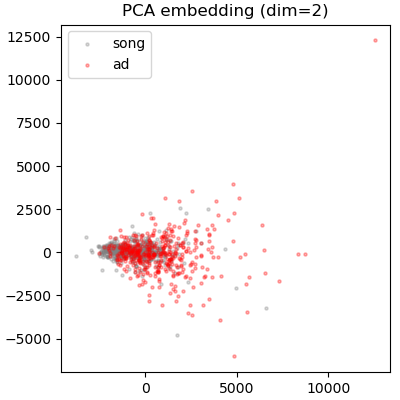

In [54]:
plt.close("all")

fig, ax = plt.subplots(figsize=(4, 4), layout="constrained")

ax.scatter(embed_pca[~y, 0], embed_pca[~y, 1],
              c="gray", label="song", alpha=0.3, s=5)
ax.scatter(embed_pca[y, 0], embed_pca[y, 1],
              c="red", label="ad", alpha=0.3, s=5)
ax.set_title(f"PCA embedding (dim={embedding_dim})")

plt.legend(loc="best")

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-PCA.png", dpi=300)

plt.show()

### Spectral Embedding

In [48]:
gamma_range = np.logspace(-2, 1, 4) 
param_grid_rbf = {
    'n_components': [2],
    'affinity': ['rbf'],
    'gamma': gamma_range,
}

neighbors_range = np.logspace(2, 8, 4, base=2, dtype=int)  
param_grid_nn = {
    'n_components': [2],
    'affinity': ['nearest_neighbors'],
    'n_neighbors': neighbors_range,
}

grid_rbf = list(ParameterGrid(param_grid_rbf))
grid_nn = list(ParameterGrid(param_grid_nn))

In [93]:
spectral_embeddings = []
for params in grid_rbf:
    spectral = SpectralEmbedding(**params)
    embed_spectral = spectral.fit_transform(X)
    spectral_embeddings.append(embed_spectral)

for params in grid_nn:
    spectral = SpectralEmbedding(**params)
    embed_spectral = spectral.fit_transform(X)
    spectral_embeddings.append(embed_spectral)

/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [94]:
params_combined = grid_rbf + grid_nn

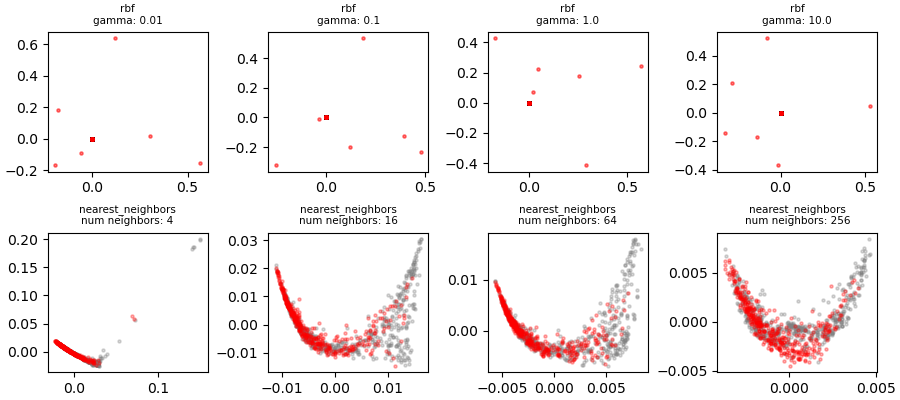

In [99]:
plt.close("all")

fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter(spectral_embeddings[i][~y, 0], spectral_embeddings[i][~y, 1], 
               c="gray", label="song", alpha=0.3, s=5)
    ax.scatter(spectral_embeddings[i][y, 0], spectral_embeddings[i][y, 1], 
               c="red", label="ad", alpha=0.3, s=5)

    if params_combined[i]["affinity"] == "rbf":
        ax.set_title(f'{params_combined[i]["affinity"]}\ngamma: {params_combined[i]["gamma"]}', fontsize=7.5)
    else:
        ax.set_title(f'{params_combined[i]["affinity"]}\nnum neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)


# plt.legend(loc="upper right")

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-spectral.png", dpi=300)

plt.show()

### t-SNE

In [53]:
# perplexity_range = np.logspace(2, 9, 8, base=2, dtype=int)
perplexity_range = [2, 32, 64, 128, 256, 512, 768, 896]
perplexity_range

[2, 32, 64, 128, 256, 512, 768, 896]

In [54]:
param_grid_tsne = {
    'n_components': [2],
    'perplexity': perplexity_range,
}

grid_tsne = list(ParameterGrid(param_grid_tsne))

In [148]:
tsne_embeddings = []
for params in grid_tsne:
    model = TSNE(**params, n_iter=10000)
    embedding = model.fit_transform(X)
    tsne_embeddings.append(embedding)

In [149]:
params_combined = grid_tsne

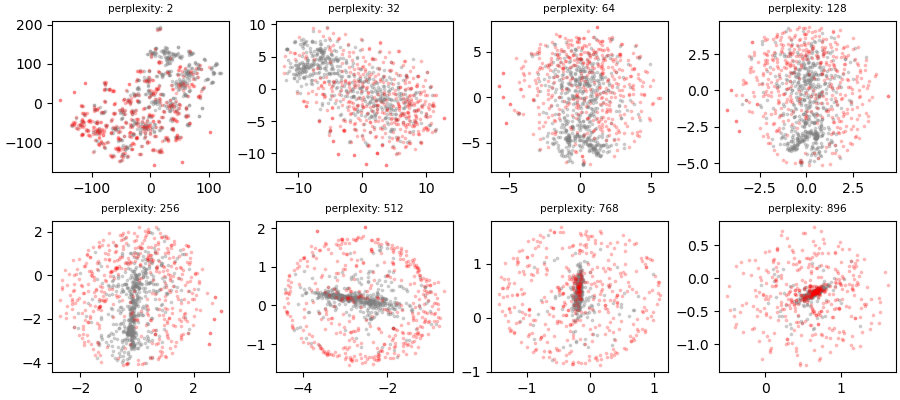

In [150]:
plt.close("all")

fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter(tsne_embeddings[i][~y, 0], tsne_embeddings[i][~y, 1], 
               c="gray", label="song", alpha=0.3, s=3)
    ax.scatter(tsne_embeddings[i][y, 0], tsne_embeddings[i][y, 1], 
               c="red", label="ad", alpha=0.2, s=3)

    ax.set_title(f'perplexity: {params_combined[i]["perplexity"]}', fontsize=7.5)


# plt.legend(loc="upper right")

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-tsne.png", dpi=300)

plt.show()

### UMAP

* euclidean
* manhattan
* chebyshev
* minkowski
* canberra
* braycurtis
* mahalanobis
* wminkowski
* seuclidean
* cosine
* correlation
* haversine
* hamming
* jaccard
* dice
* russelrao
* kulsinski
* ll_dirichlet
* hellinger
* rogerstanimoto
* sokalmichener
* sokalsneath
* yule

In [56]:
nn_range = [2, 5, 15, 50, 100, 150, 200, 500]
metric_range = ["chebychev"]

In [57]:
param_grid_umap = {
    'n_components': [2],
    'min_dist': [0.0],
    'n_neighbors': nn_range,
    'metric': metric_range 
}
grid_umap = list(ParameterGrid(param_grid_umap))

In [168]:
params_combined = grid_umap

In [169]:
umap_embeddings = []
for params in grid_umap:
    model = umap.UMAP(**params)
    embedding = model.fit_transform(X)
    umap_embeddings.append(embedding)

/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


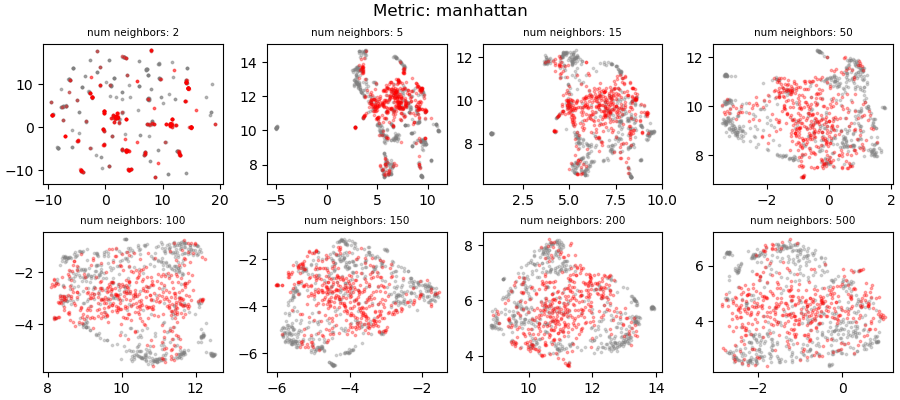

In [170]:
plt.close("all")

fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")

axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.scatter(umap_embeddings[i][~y, 0], umap_embeddings[i][~y, 1], 
               c="gray", label="song", alpha=0.3, s=3)
    ax.scatter(umap_embeddings[i][y, 0], umap_embeddings[i][y, 1], 
               c="red", label="ad", alpha=0.3, s=3)

    ax.set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)

# plt.legend(loc="upper right")

fig.suptitle(f'Metric: {params_combined[i]["metric"]}')

plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-umap-{params_combined[i]['metric']}.png", dpi=300)

plt.show()

In [33]:
nn_range = [2, 5, 15, 50, 100, 150, 200, 500]

In [37]:
distance_metrics = [
    # "euclidean",
    # "manhattan",
    # "chebyshev",
    # "minkowski",
    # "canberra",
    # "braycurtis",
    # "wminkowski",
    # "cosine",
    # "correlation",
    # "hamming",
    # "jaccard",
    # "dice",
    # "kulsinski",
    # "ll_dirichlet",
    "rogerstanimoto",
    "sokalmichener",
    "sokalsneath",
    "yule"
]

In [38]:
import tqdm
from tqdm import tqdm

In [39]:
for metric_range in tqdm(distance_metrics):
    param_grid_umap = {
        'n_components': [2],
        'min_dist': [0.0],
        'n_neighbors': nn_range,
        'metric': [metric_range] 
    }
    grid_umap = list(ParameterGrid(param_grid_umap))

    params_combined = grid_umap

    # project datapoints to embedding
    umap_embeddings = []
    for params in grid_umap:
        model = umap.UMAP(**params)
        embedding = model.fit_transform(X)
        umap_embeddings.append(embedding)


    # plot
    plt.close("all")
    
    fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")
    
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.scatter(umap_embeddings[i][~y, 0], umap_embeddings[i][~y, 1], 
                   c="gray", label="song", alpha=0.3, s=3)
        ax.scatter(umap_embeddings[i][y, 0], umap_embeddings[i][y, 1], 
                   c="red", label="ad", alpha=0.3, s=3)
    
        ax.set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)
    
    # plt.legend(loc="upper right")
    
    fig.suptitle(f'Metric: {params_combined[i]["metric"]}')
    
    plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-umap-{params_combined[i]['metric']}.png", dpi=300)
    
    plt.close("all")

  0%|                                                     | 0/4 [00:00<?, ?it/s]/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for rogerstanimoto distance metric; inverse_transform will be unavailable
  warn(
/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/u

Supervised clustering with UMAP

In [40]:
distance_metrics = [
    "euclidean",
    "manhattan",
    "chebyshev",
    "minkowski",
    "canberra",
    "braycurtis",
    "wminkowski",
    "cosine",
    "correlation",
    "hamming",
    "jaccard",
    "dice",
    "kulsinski",
    "ll_dirichlet",
    "rogerstanimoto",
    "sokalmichener",
    "sokalsneath",
    "yule"
]

In [42]:
target = [1 if x else 0 for x in y]

In [43]:
for metric_range in tqdm(distance_metrics):
    param_grid_umap = {
        'n_components': [2],
        'min_dist': [0.0],
        'n_neighbors': nn_range,
        'metric': [metric_range] 
    }
    grid_umap = list(ParameterGrid(param_grid_umap))

    params_combined = grid_umap

    # project datapoints to embedding
    umap_embeddings = []
    for params in grid_umap:
        model = umap.UMAP(**params)
        embedding = model.fit_transform(X, y=target)
        umap_embeddings.append(embedding)


    # plot
    plt.close("all")
    
    fig, axes = plt.subplots(2, 4, figsize=(9, 4), layout="constrained")
    
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.scatter(umap_embeddings[i][~y, 0], umap_embeddings[i][~y, 1], 
                   c="gray", label="song", alpha=0.3, s=3)
        ax.scatter(umap_embeddings[i][y, 0], umap_embeddings[i][y, 1], 
                   c="red", label="ad", alpha=0.3, s=3)
    
        ax.set_title(f'num neighbors: {params_combined[i]["n_neighbors"]}', fontsize=7.5)
    
    # plt.legend(loc="upper right")
    
    fig.suptitle(f'Metric: {params_combined[i]["metric"]}')
    
    plt.savefig(f"graphics/embedding-{DAT_TYPE}-{embedding_dim}d-supervised-umap-{params_combined[i]['metric']}.png", dpi=300)
    
    plt.close("all")

  0%|                                                    | 0/18 [00:00<?, ?it/s]/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
  6%|██▍                                         | 1/18 [01:02<17:50, 62.98s/it]/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 11%|████▊                                      | 2/18 [03:21<28:37, 107.33s/it]/opt/miniconda3/envs/audio-env/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 17%|███████▏                                   | 3/18 [05:41<30:36, 122.45s/it]/opt/miniconda3/envs/audio-env/lib/python3.9/site-pac

## Plots

In [60]:
embedding_dim = 3

In [66]:
pca = PCA(n_components=embedding_dim)
model_pca = pca.fit(X)
embed_pca = model_pca.transform(X)
fit_variances = model_pca.explained_variance_ratio_

spectral = SpectralEmbedding(**{'affinity': 'nearest_neighbors', 'n_components': embedding_dim, 'n_neighbors': 16})
embed_spectral = spectral.fit_transform(X)

model = TSNE(**{'n_components': embedding_dim, 'perplexity': 256}, n_iter=10000)
embed_tnse = model.fit_transform(X)

model = umap.UMAP(**{'metric': 'chebyshev', 'min_dist': 0.0, 'n_components': embedding_dim, 'n_neighbors': 50})
embed_umap = model.fit_transform(X)

In [68]:
%matplotlib widget

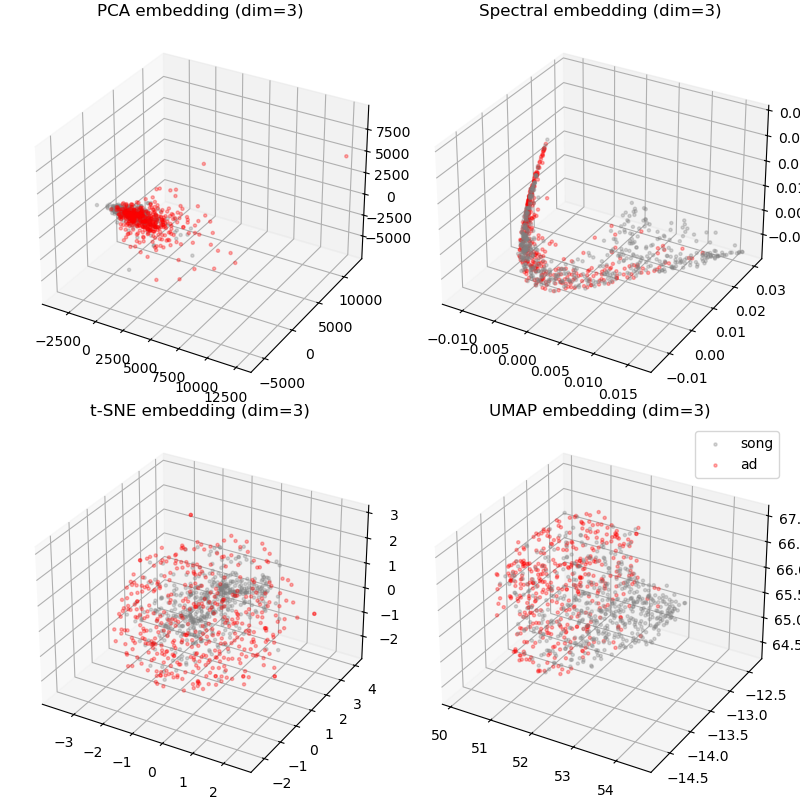

In [69]:
plt.close("all")

fig, ax = plt.subplots(2, 2, figsize=(8, 8), layout="constrained", subplot_kw=dict(projection="3d"))

ax = ax.flatten()

ax[0].scatter3D(embed_pca[~y, 0], embed_pca[~y, 1], embed_pca[~y, 2],
              c="gray", label="song", alpha=0.3, s=5)
ax[0].scatter3D(embed_pca[y, 0], embed_pca[y, 1], embed_pca[y, 2],
              c="red", label="ad", alpha=0.3, s=5)
ax[0].set_title(f"PCA embedding (dim={embedding_dim})")


ax[1].scatter3D(embed_spectral[~y, 0], embed_spectral[~y, 1], embed_spectral[~y, 2],
              c="gray", label="song", alpha=0.3, s=5)
ax[1].scatter3D(embed_spectral[y, 0], embed_spectral[y, 1], embed_spectral[y, 2],
              c="red", label="ad", alpha=0.3, s=5)
ax[1].set_title(f"Spectral embedding (dim={embedding_dim})")


ax[2].scatter3D(embed_tnse[~y, 0], embed_tnse[~y, 1], embed_tnse[~y, 2],
              c="gray", label="song", alpha=0.3, s=5)
ax[2].scatter3D(embed_tnse[y, 0], embed_tnse[y, 1], embed_tnse[y, 2],
              c="red", label="ad", alpha=0.3, s=5)
ax[2].set_title(f"t-SNE embedding (dim={embedding_dim})")


ax[3].scatter3D(embed_umap[~y, 0], embed_umap[~y, 1], embed_umap[~y, 2],
              c="gray", label="song", alpha=0.3, s=5)
ax[3].scatter3D(embed_umap[y, 0], embed_umap[y, 1], embed_umap[y, 2],
              c="red", label="ad", alpha=0.3, s=5)
ax[3].set_title(f"UMAP embedding (dim={embedding_dim})")

plt.legend(loc="best")

# plt.savefig(f"graphics/embedding-{embedding_dim}d.png", dpi=300)

plt.show()